# 轨迹偏移的处理

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [8]:
#采用众数去替换静止时的经纬度
def jingzhidian(data):
    a=[]
    for i in range(0,len(data)):
        if(data['活动状态'][i]==1):
            a.append(i)
    print(a)

    star=0
    for i in range(0,len(a)):#0-206
        if(i<len(a)):
            if(a[i]-a[i-1]>3):
                # 计算众数
                mode_val_1 = data.iloc[star:a[i]]['经度'].value_counts().idxmax()
                mode_val_2 = data.iloc[star:a[i]]['纬度'].value_counts().idxmax()
                for j in range(star,a[i]):
                    data['经度'][j]=mode_val_1
                    data['纬度'][j]=mode_val_2
        else:
            if(len(data)-a[i]>3):
                print(star)
                mode_val_1 = data.iloc[star:a[i]]['经度'].value_counts().idxmax()
                mode_val_2 = data.iloc[star:a[i]]['纬度'].value_counts().idxmax()
                for j in range(star,a[i]):
                    data['经度'][j]=mode_val_1
                    data['纬度'][j]=mode_val_2
        star=a[i]+3
    return data

In [9]:
# 卡尔曼滤波
class KalmanFilter:  
    def __init__(self, process_variance, measurement_variance,x,y): #构造方法
        self.x = np.array([[x], [y]])  # 初始状态：经度和纬度  
        self.P = np.eye(2) * 1.0  # 初始协方差矩阵  
        self.A = np.eye(2)  # 状态转移矩阵  
        self.Q = np.eye(2) * process_variance  # 过程噪声协方差矩阵  
        self.H = np.eye(2)  # 观测矩阵  
        self.R = np.eye(2) * measurement_variance  # 测量噪声协方差矩阵  
  
    def update(self, z):  
        # 预测  
        x_pred = np.dot(self.A, self.x)  
        P_pred = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q  #self.A.T为self.A的转置矩阵   （（A*P）*A-1）+Q
  
        # 更新  
        S = np.dot(np.dot(self.H, P_pred), self.H.T) + self.R  
        K = np.dot(np.dot(P_pred, self.H.T), np.linalg.inv(S))  #np.linalg.inv(S)计算S矩阵的逆矩阵
        self.x = x_pred + np.dot(K, (z - np.dot(self.H, x_pred))) #更新经纬度的坐标，为下一次预测的初始状态
        self.P = np.dot((np.eye(len(self.x)) - np.dot(K, self.H)), P_pred) #更新协方差矩阵
  
    def get_state(self):  
        return self.x 

In [10]:
# 中值滤波
def zhongzhi(data,step):#data表示数据集，step表示步长即前后取的点数
    long=len(data)
    step=step
    star_index=step
    end_index=long-step
    for i in range(star_index,end_index):
        a=data.iloc[i-step:i+step+1].sort_values(by='经度')
        data.at[i, '经度']=a.iloc[step][1]
        b=data.iloc[i-step:i+step+1].sort_values(by='纬度')
        data.at[i, '纬度']=b.iloc[step][2]
    return data

In [11]:
#线性插值
def xianxingchazhi(data):
    
    drop_arr=[]
    result_arr=[]
    for i in range(0,data(len)):
        if(data.iloc[i]['定位状态']==1):
            drop_arr.append(i)
        else:
            result_arr.append(i)
    
    # 定义要删除的索引列表  
    # 使用 ~isin 来生成一个布尔索引，这个索引在要删除的索引位置为 False，其他位置为 True  
    bool_index = ~data.index.isin(drop_arr)  

    # 使用这个布尔索引来过滤 DataFrame，得到不包含这些索引的行  
    filtered_data_3 = data.loc[bool_index]  

    # 如果你想要直接修改原始的 DataFrame  
    # 注意：这将改变 data_3，且不会返回任何值（除非你重新赋值给 data_3）  
    # data_3 = data_3.loc[~data_3.index.isin(indices_to_drop)]  
    
    #线性插值
    # 假设 data_3 是已经存在的 DataFrame，且其索引与 times 数组对应  
    # ... 这里应该是 data_3 的创建或加载代码 ...  

    # 假设的经纬度数据点（按时间顺序排列）  
    times = np.array(result_arr)  # 时间点  
    longitudes = np.array(filtered_data_3['经度'])  # 经度  
    latitudes = np.array(filtered_data_3['纬度'])        # 纬度  

    # 缺失点的时间  
    # drop_arr = [2.5, 3.5]  # 假设这是缺失的时间点列表  

    for missing_time in drop_arr:  
        # 找到缺失时间点之前的点  
        prev_idx = None  
        for i, t in enumerate(times):  
            if t <= missing_time:  
                prev_idx = i  
                if i + 1 < len(times) and times[i + 1] > missing_time:  
                    break  

        # 进行插值  
        if prev_idx is not None and prev_idx + 1 < len(times):  
            t0, t1 = times[prev_idx], times[prev_idx + 1]  
            lon0, lon1 = longitudes[prev_idx], longitudes[prev_idx + 1]  
            lat0, lat1 = latitudes[prev_idx], latitudes[prev_idx + 1]  

            # 线性插值公式  
            lon_missing = lon0 + (lon1 - lon0) * (missing_time - t0) / (t1 - t0)  
            lat_missing = lat0 + (lat1 - lat0) * (missing_time - t0) / (t1 - t0)  

            # 这里假设 data_3 的索引与 times 数组相同  
            # 替换掉表中的数据（如果 data_3 的索引是整数且基于时间点的顺序）  
            # 注意：如果 data_3 的索引不是整数或不是基于时间点，则需要相应地调整索引  
            if missing_time in data.index:  # 确保索引在 DataFrame 中  
                data.at[data.index[missing_time], '经度'] = round(lon_missing, 6)  
                data.at[data.index[missing_time], '纬度'] = round(lat_missing, 6)  
            else:  
                print(f"Index {prev_idx} is not in data_3") 
        else:  
            print(f"Missing time point {missing_time} is out of bounds or there are not enough data points for interpolation.")
    return data

In [12]:
# 三次样条插值
def interpolate_cubic_spline_by_index(series):  
    # 移除NaN值  
    valid_indices = series[~np.isnan(series)].index  
    valid_values = series[~np.isnan(series)]  
      
    # 如果没有足够的数据点进行插值，则返回原始序列（或可以填充为NaN）  
    if len(valid_indices) < 2:  # 三次样条至少需要两个点  
        return series.fillna(np.nan)  
      
    # 使用DataFrame的索引作为插值的x坐标  
    x_vals = np.array(valid_indices, dtype=float)  # 确保x_vals是浮点数数组（尽管在这个例子中可能是整数）  
      
    # 使用CubicSpline进行插值  
    spline = CubicSpline(x_vals, valid_values)  
      
    # 对所有索引进行插值（这里我们假设索引是连续的整数，如果不连续，则需要先调整）  
    # 但为了简化，我们直接对整个索引范围进行插值，并替换原始NaN值  
    all_indices = np.arange(len(series))  
    interpolated_values = spline(all_indices)  
      
    # 创建一个新的Series来存储插值结果  
    interpolated_series = pd.Series(interpolated_values, index=series.index)  
      
    # 返回插值后的Series  
    return interpolated_series  

In [13]:
data=pd.read_excel("D:/data/0280/0280原始数据.xlsx")
data

,序号,设备状态,数据类型,定位时间,设备名称,设备编码,经度,纬度,获取位置,警报状态,事件,电量,定位方式,方向,海拔高度,速度
0,1,"锁杆开,无充电,解封,静止,短连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-07-29 10:02:28,489076140280,489076140280,113.797464,22.688276,获取定位,外壳破坏报警,NaN,68%,GPS有效定位,326,74,0.0
1,2,"锁杆开,无充电,解封,静止,短连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-07-29 10:02:58,489076140280,489076140280,113.797464,22.688276,获取定位,外壳破坏报警,NaN,68%,GPS有效定位,326,74,0.0
2,3,"锁杆开,无充电,解封,静止,短连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-07-29 10:03:28,489076140280,489076140280,113.797464,22.688276,获取定位,外壳破坏报警,NaN,68%,GPS有效定位,326,74,0.0
3,4,"锁杆开,无充电,解封,静止,短连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-07-29 10:03:58,489076140280,489076140280,113.797464,22.688276,获取定位,外壳破坏报警,NaN,68%,GPS有效定位,326,74,0.0
4,5,"锁杆开,无充电,解封,静止,短连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-07-29 10:04:28,489076140280,489076140280,113.797464,22.688276,获取定位,外壳破坏报警,NaN,68%,GPS有效定位,326,74,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8848,8849,"锁杆开,无充电,解封,静止,长连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-08-01 15:28:50,489076140280,489076140280,113.943112,22.688810,获取定位,NaN,NaN,64%,GPS有效定位,252,69,0.0
8849,8850,"锁杆开,无充电,解封,静止,长连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-08-01 15:29:20,489076140280,489076140280,113.943112,22.688810,获取定位,NaN,NaN,63%,GPS有效定位,252,69,0.0
8850,8851,"锁杆开,无充电,解封,静止,长连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-08-01 15:29:50,489076140280,489076140280,113.943112,22.688810,获取定位,NaN,NaN,63%,GPS有效定位,252,69,0.0
8851,8852,"锁杆开,无充电,解封,静止,长连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-08-01 15:30:20,489076140280,489076140280,113.943112,22.688810,获取定位,NaN,NaN,63%,GPS有效定位,252,69,0.0


In [14]:
# # 删除'A'列中值为0的行  
# data = data[data['定位方式'] != 'LBS']
# data
# # 重置索引列
# data = data.reset_index(drop=True)
# data

In [15]:
# 删除'A'列中值为0的行  
data = data[data['经度'] != 0]
data
# 重置索引列
data = data.reset_index(drop=True)
data

,序号,设备状态,数据类型,定位时间,设备名称,设备编码,经度,纬度,获取位置,警报状态,事件,电量,定位方式,方向,海拔高度,速度
0,1,"锁杆开,无充电,解封,静止,短连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-07-29 10:02:28,489076140280,489076140280,113.797464,22.688276,获取定位,外壳破坏报警,NaN,68%,GPS有效定位,326,74,0.0
1,2,"锁杆开,无充电,解封,静止,短连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-07-29 10:02:58,489076140280,489076140280,113.797464,22.688276,获取定位,外壳破坏报警,NaN,68%,GPS有效定位,326,74,0.0
2,3,"锁杆开,无充电,解封,静止,短连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-07-29 10:03:28,489076140280,489076140280,113.797464,22.688276,获取定位,外壳破坏报警,NaN,68%,GPS有效定位,326,74,0.0
3,4,"锁杆开,无充电,解封,静止,短连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-07-29 10:03:58,489076140280,489076140280,113.797464,22.688276,获取定位,外壳破坏报警,NaN,68%,GPS有效定位,326,74,0.0
4,5,"锁杆开,无充电,解封,静止,短连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-07-29 10:04:28,489076140280,489076140280,113.797464,22.688276,获取定位,外壳破坏报警,NaN,68%,GPS有效定位,326,74,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8822,8849,"锁杆开,无充电,解封,静止,长连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-08-01 15:28:50,489076140280,489076140280,113.943112,22.688810,获取定位,NaN,NaN,64%,GPS有效定位,252,69,0.0
8823,8850,"锁杆开,无充电,解封,静止,长连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-08-01 15:29:20,489076140280,489076140280,113.943112,22.688810,获取定位,NaN,NaN,63%,GPS有效定位,252,69,0.0
8824,8851,"锁杆开,无充电,解封,静止,长连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-08-01 15:29:50,489076140280,489076140280,113.943112,22.688810,获取定位,NaN,NaN,63%,GPS有效定位,252,69,0.0
8825,8852,"锁杆开,无充电,解封,静止,长连接,东经,北纬,网络状态缺省,关闭,卡1,GPS有效定位",实时数据,2024-08-01 15:30:20,489076140280,489076140280,113.943112,22.688810,获取定位,NaN,NaN,63%,GPS有效定位,252,69,0.0


In [16]:
# 定义一个函数来提取指定位置的字段内容
def extract_field(text, position):
    # 根据逗号分隔字符串
    fields = text.split(',')
    
    # 确保位置有效
    if position < len(fields):
        return fields[position]
    else:
        return None

In [17]:
# 获取 DataFrame 中指定列的第三个逗号后面第四个字段内容
# 注意位置是从0开始的，所以第四个字段位置是3
data['活动状态'] = data['设备状态'].apply(lambda x: extract_field(x, 3))
data=data[['定位时间','经度','纬度','活动状态','定位方式','方向','速度']]
data

,定位时间,经度,纬度,活动状态,定位方式,方向,速度
0,2024-07-29 10:02:28,113.797464,22.688276,静止,GPS有效定位,326,0.0
1,2024-07-29 10:02:58,113.797464,22.688276,静止,GPS有效定位,326,0.0
2,2024-07-29 10:03:28,113.797464,22.688276,静止,GPS有效定位,326,0.0
3,2024-07-29 10:03:58,113.797464,22.688276,静止,GPS有效定位,326,0.0
4,2024-07-29 10:04:28,113.797464,22.688276,静止,GPS有效定位,326,0.0
...,...,...,...,...,...,...,...
8822,2024-08-01 15:28:50,113.943112,22.688810,静止,GPS有效定位,252,0.0
8823,2024-08-01 15:29:20,113.943112,22.688810,静止,GPS有效定位,252,0.0
8824,2024-08-01 15:29:50,113.943112,22.688810,静止,GPS有效定位,252,0.0
8825,2024-08-01 15:30:20,113.943112,22.688810,静止,GPS有效定位,252,0.0


In [18]:
#将文字类型转换为数字类型
data['活动状态']=data['活动状态'].map({'静止':0,'运动':1})
data['定位方式']=data['定位方式'].map({'GPS有效定位':0,'GPS无效定位':1,'LBS':1})
data

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7200\2643871110.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['活动状态']=data['活动状态'].map({'静止':0,'运动':1})
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7200\2643871110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['定位方式']=data['定位方式'].map({'GPS有效定位':0,'GPS无效定位':1,'LBS':1})


,定位时间,经度,纬度,活动状态,定位方式,方向,速度
0,2024-07-29 10:02:28,113.797464,22.688276,0,0,326,0.0
1,2024-07-29 10:02:58,113.797464,22.688276,0,0,326,0.0
2,2024-07-29 10:03:28,113.797464,22.688276,0,0,326,0.0
3,2024-07-29 10:03:58,113.797464,22.688276,0,0,326,0.0
4,2024-07-29 10:04:28,113.797464,22.688276,0,0,326,0.0
...,...,...,...,...,...,...,...
8822,2024-08-01 15:28:50,113.943112,22.688810,0,0,252,0.0
8823,2024-08-01 15:29:20,113.943112,22.688810,0,0,252,0.0
8824,2024-08-01 15:29:50,113.943112,22.688810,0,0,252,0.0
8825,2024-08-01 15:30:20,113.943112,22.688810,0,0,252,0.0


In [19]:
data_original=data.copy()

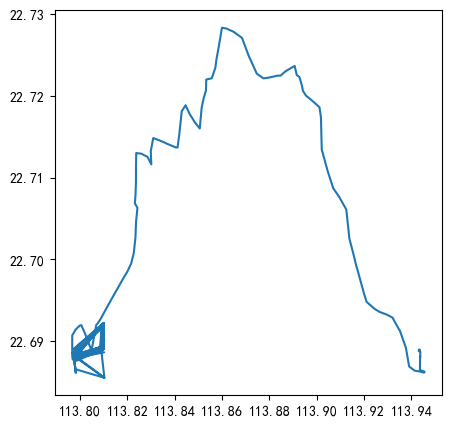

In [20]:
x= data_original[['经度']]
y =data_original[['纬度']]
plt.figure(figsize=(5, 5), dpi=100)
plt.plot(x, y)
plt.show()

In [21]:
#选择定位无效的定位点经纬度，并且使用np.nan填充
drop_arr=[]    #定位无效的索引
result_arr=[]  #定位有效的索引
for i in range(0,1960):
    if(data.iloc[i]['定位方式']!=0):
        data.at[i,'经度']=np.nan
        data.at[i,'纬度']=np.nan
        drop_arr.append(i)
    else:
        result_arr.append(i)

In [22]:
# 对经度和纬度进行插值  
data['经度'] = interpolate_cubic_spline_by_index(data['经度'])
data['纬度'] = interpolate_cubic_spline_by_index(data['纬度'])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7200\1938104361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['经度'] = interpolate_cubic_spline_by_index(data['经度'])
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7200\1938104361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['纬度'] = interpolate_cubic_spline_by_index(data['纬度'])


In [23]:
data

,定位时间,经度,纬度,活动状态,定位方式,方向,速度
0,2024-07-29 10:02:28,113.797464,22.688276,0,0,326,0.0
1,2024-07-29 10:02:58,113.797464,22.688276,0,0,326,0.0
2,2024-07-29 10:03:28,113.797464,22.688276,0,0,326,0.0
3,2024-07-29 10:03:58,113.797464,22.688276,0,0,326,0.0
4,2024-07-29 10:04:28,113.797464,22.688276,0,0,326,0.0
...,...,...,...,...,...,...,...
8822,2024-08-01 15:28:50,113.943112,22.688810,0,0,252,0.0
8823,2024-08-01 15:29:20,113.943112,22.688810,0,0,252,0.0
8824,2024-08-01 15:29:50,113.943112,22.688810,0,0,252,0.0
8825,2024-08-01 15:30:20,113.943112,22.688810,0,0,252,0.0


In [24]:
data=jingzhidian(data)

[15, 42, 85, 92, 169, 176, 179, 218, 361, 421, 468, 469, 470, 471, 472, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 504, 505, 506, 507, 508, 509, 510, 512, 514, 515, 522, 540, 541, 545, 546, 547, 548, 549, 550, 551, 566, 605, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 641, 644, 646, 647, 648, 651, 652, 653, 654, 655, 656, 657, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 680, 681, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 734, 736, 737, 738, 739, 740, 741, 743, 744, 745, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7200\3342271205.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['经度'][j]=mode_val_1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7200\3342271205.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['纬度'][j]=mode_val_2
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7200\3342271205.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['经度'][j]=mode_val_1
C

In [25]:
data.iloc[647]

定位时间    2024-07-29 17:49:17
经度               113.797597
纬度                22.688203
活动状态                      1
定位方式                      1
方向                        0
速度                      0.0
Name: 647, dtype: object

In [26]:
#中值滤波
data=zhongzhi(data,step=2)
data


# #卡尔曼滤波
# kf = KalmanFilter(process_variance=0.1, measurement_variance=0.1,x=data['经度'][0],y=data['纬度'][0])  

# # 假设这是不准确的经纬度观测值  
# measurements = []  
# for index, row in data.iterrows():  
#     # 提取经度和纬度，并创建NumPy数组  
#     measurement = np.array([[row['经度']], [row['纬度']]])  
#     # 将NumPy数组添加到measurements列表中  
#     measurements.append(measurement)

# estimated_coords = []

# # 对每个观测值进行更新  
# for z in measurements:  
#     kf.update(z)
#     x = kf.get_state()[0, 0]  # 注意这里使用了numpy的索引方式，假设get_state()返回的是numpy数组  
#     y = kf.get_state()[1, 0]
#     estimated_coords.append({'经度': x, '纬度': y})   # 将估计的(x, y)坐标添加到列表中
# data[['经度','纬度']]=pd.DataFrame(estimated_coords)
# data

,定位时间,经度,纬度,活动状态,定位方式,方向,速度
0,2024-07-29 10:02:28,113.797464,22.688276,0,0,326,0.0
1,2024-07-29 10:02:58,113.797464,22.688276,0,0,326,0.0
2,2024-07-29 10:03:28,113.797464,22.688276,0,0,326,0.0
3,2024-07-29 10:03:58,113.797464,22.688276,0,0,326,0.0
4,2024-07-29 10:04:28,113.797464,22.688276,0,0,326,0.0
...,...,...,...,...,...,...,...
8822,2024-08-01 15:28:50,113.943112,22.688810,0,0,252,0.0
8823,2024-08-01 15:29:20,113.943112,22.688810,0,0,252,0.0
8824,2024-08-01 15:29:50,113.943112,22.688810,0,0,252,0.0
8825,2024-08-01 15:30:20,113.943112,22.688810,0,0,252,0.0


In [28]:
data.describe()

,经度,纬度,活动状态,定位方式,方向,速度
count,8827.000000,8827.000000,8827.000000,8827.000000,8827.000000,8827.000000
mean,113.929646,22.688956,0.033987,0.032740,240.038405,0.329161
std,0.041725,0.002478,0.181205,0.177967,52.953913,3.141324
min,113.796792,22.686284,0.000000,0.000000,0.000000,0.000000
25%,113.943112,22.688810,0.000000,0.000000,252.000000,0.000000
50%,113.943112,22.688810,0.000000,0.000000,252.000000,0.000000
75%,113.943112,22.688810,0.000000,0.000000,252.000000,0.000000
max,113.943688,22.727844,1.000000,1.000000,359.000000,55.700000


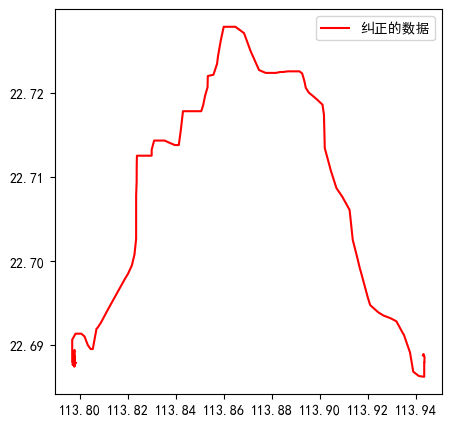

In [30]:
x= data[['经度']]
y =data[['纬度']]
plt.figure(figsize=(5, 5),dpi=100)
plt.plot(x, y,'-r',label='纠正的数据')
# plt.plot(data_original[['经度']],data_original[['纬度']],label='原始数据')
plt.legend()
plt.show()

In [58]:
# 保存数据
# data.to_excel("D:/data/0280/0280_zhongzhi.xlsx",index=True,header=True)

In [116]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.interpolate import CubicSpline
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

# #采用众数去替换静止时的经纬度
# def jingzhidian(data):
#     a=[]
#     for i in range(0,len(data)):
#         if(data['活动状态'][i]==1):
#             a.append(i)
#     print(a)

#     star=0
#     for i in range(0,len(a)):#0-206
#         if(i<len(a)):
#             if(a[i]-a[i-1]>3):
#                 # 计算众数
#                 mode_val_1 = data.iloc[star:a[i]]['经度'].value_counts().idxmax()
#                 mode_val_2 = data.iloc[star:a[i]]['纬度'].value_counts().idxmax()
#                 for j in range(star,a[i]):
#                     data['经度'][j]=mode_val_1
#                     data['纬度'][j]=mode_val_2
#         else:
#             if(len(data)-a[i]>3):
#                 print(star)
#                 mode_val_1 = data.iloc[star:a[i]]['经度'].value_counts().idxmax()
#                 mode_val_2 = data.iloc[star:a[i]]['纬度'].value_counts().idxmax()
#                 for j in range(star,a[i]):
#                     data['经度'][j]=mode_val_1
#                     data['纬度'][j]=mode_val_2
#         star=a[i]+3
#     return data

# # 卡尔曼滤波
# class KalmanFilter:  
#     def __init__(self, process_variance, measurement_variance,x,y): #构造方法
#         self.x = np.array([[x], [y]])  # 初始状态：经度和纬度  
#         self.P = np.eye(2) * 1.0  # 初始协方差矩阵  
#         self.A = np.eye(2)  # 状态转移矩阵  
#         self.Q = np.eye(2) * process_variance  # 过程噪声协方差矩阵  
#         self.H = np.eye(2)  # 观测矩阵  
#         self.R = np.eye(2) * measurement_variance  # 测量噪声协方差矩阵  
  
#     def update(self, z):  
#         # 预测  
#         x_pred = np.dot(self.A, self.x)  
#         P_pred = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q  #self.A.T为self.A的转置矩阵   （（A*P）*A-1）+Q
  
#         # 更新  
#         S = np.dot(np.dot(self.H, P_pred), self.H.T) + self.R  
#         K = np.dot(np.dot(P_pred, self.H.T), np.linalg.inv(S))  #np.linalg.inv(S)计算S矩阵的逆矩阵
#         self.x = x_pred + np.dot(K, (z - np.dot(self.H, x_pred))) #更新经纬度的坐标，为下一次预测的初始状态
#         self.P = np.dot((np.eye(len(self.x)) - np.dot(K, self.H)), P_pred) #更新协方差矩阵
  
#     def get_state(self):  
#         return self.x 
    
    
# # 中值滤波
# def zhongzhi(data,step):#data表示数据集，step表示步长即前后取的点数
#     long=len(data)
#     step=step
#     star_index=step
#     end_index=long-step
#     for i in range(star_index,end_index):
#         a=data.iloc[i-step:i+step+1].sort_values(by='经度')
#         data.at[i, '经度']=a.iloc[step][1]
#         b=data.iloc[i-step:i+step+1].sort_values(by='纬度')
#         data.at[i, '纬度']=b.iloc[step][2]
#     return data

# #线性插值
# def xianxingchazhi(data):
    
#     drop_arr=[]
#     result_arr=[]
#     for i in range(0,data(len)):
#         if(data.iloc[i]['定位状态']==1):
#             drop_arr.append(i)
#         else:
#             result_arr.append(i)
    
#     # 定义要删除的索引列表  
#     # 使用 ~isin 来生成一个布尔索引，这个索引在要删除的索引位置为 False，其他位置为 True  
#     bool_index = ~data.index.isin(drop_arr)  

#     # 使用这个布尔索引来过滤 DataFrame，得到不包含这些索引的行  
#     filtered_data_3 = data.loc[bool_index]  

#     # 如果你想要直接修改原始的 DataFrame  
#     # 注意：这将改变 data_3，且不会返回任何值（除非你重新赋值给 data_3）  
#     # data_3 = data_3.loc[~data_3.index.isin(indices_to_drop)]  
    
#     #线性插值
#     # 假设 data_3 是已经存在的 DataFrame，且其索引与 times 数组对应  
#     # ... 这里应该是 data_3 的创建或加载代码 ...  

#     # 假设的经纬度数据点（按时间顺序排列）  
#     times = np.array(result_arr)  # 时间点  
#     longitudes = np.array(filtered_data_3['经度'])  # 经度  
#     latitudes = np.array(filtered_data_3['纬度'])        # 纬度  

#     # 缺失点的时间  
#     # drop_arr = [2.5, 3.5]  # 假设这是缺失的时间点列表  

#     for missing_time in drop_arr:  
#         # 找到缺失时间点之前的点  
#         prev_idx = None  
#         for i, t in enumerate(times):  
#             if t <= missing_time:  
#                 prev_idx = i  
#                 if i + 1 < len(times) and times[i + 1] > missing_time:  
#                     break  

#         # 进行插值  
#         if prev_idx is not None and prev_idx + 1 < len(times):  
#             t0, t1 = times[prev_idx], times[prev_idx + 1]  
#             lon0, lon1 = longitudes[prev_idx], longitudes[prev_idx + 1]  
#             lat0, lat1 = latitudes[prev_idx], latitudes[prev_idx + 1]  

#             # 线性插值公式  
#             lon_missing = lon0 + (lon1 - lon0) * (missing_time - t0) / (t1 - t0)  
#             lat_missing = lat0 + (lat1 - lat0) * (missing_time - t0) / (t1 - t0)  

#             # 这里假设 data_3 的索引与 times 数组相同  
#             # 替换掉表中的数据（如果 data_3 的索引是整数且基于时间点的顺序）  
#             # 注意：如果 data_3 的索引不是整数或不是基于时间点，则需要相应地调整索引  
#             if missing_time in data.index:  # 确保索引在 DataFrame 中  
#                 data.at[data.index[missing_time], '经度'] = round(lon_missing, 6)  
#                 data.at[data.index[missing_time], '纬度'] = round(lat_missing, 6)  
#             else:  
#                 print(f"Index {prev_idx} is not in data_3") 
#         else:  
#             print(f"Missing time point {missing_time} is out of bounds or there are not enough data points for interpolation.")
#     return data

# # 三次样条插值
# def interpolate_cubic_spline_by_index(series):  
#     # 移除NaN值  
#     valid_indices = series[~np.isnan(series)].index  
#     valid_values = series[~np.isnan(series)]  
      
#     # 如果没有足够的数据点进行插值，则返回原始序列（或可以填充为NaN）  
#     if len(valid_indices) < 2:  # 三次样条至少需要两个点  
#         return series.fillna(np.nan)  
      
#     # 使用DataFrame的索引作为插值的x坐标  
#     x_vals = np.array(valid_indices, dtype=float)  # 确保x_vals是浮点数数组（尽管在这个例子中可能是整数）  
      
#     # 使用CubicSpline进行插值  
#     spline = CubicSpline(x_vals, valid_values)  
      
#     # 对所有索引进行插值（这里我们假设索引是连续的整数，如果不连续，则需要先调整）  
#     # 但为了简化，我们直接对整个索引范围进行插值，并替换原始NaN值  
#     all_indices = np.arange(len(series))  
#     interpolated_values = spline(all_indices)  
      
#     # 创建一个新的Series来存储插值结果  
#     interpolated_series = pd.Series(interpolated_values, index=series.index)  
      
#     # 返回插值后的Series  
#     return interpolated_series

# data=pd.read_excel("D:/data/HistoricalTrack.xlsx")

# data['活动状态'] = data['设备状态'].str[30:32]
# data['定位状态'] = data['设备状态'].str[5:12]
# data=data[['定位时间','经度','纬度','活动状态','定位状态']]

# #将文字类型转换为数字类型
# data['活动状态']=data['活动状态'].map({'静止':0,'运动':1})
# data['定位状态']=data['定位状态'].map({'GPS有效定位':0,'GPS无效定位':1})

# #选择定位无效的定位点经纬度，并且使用np.nan填充
# drop_arr=[]    #定位无效的索引
# result_arr=[]  #定位有效的索引
# for i in range(0,1960):
#     if(data.iloc[i]['定位状态']==1):
#         data.at[i,'经度']=np.nan
#         data.at[i,'纬度']=np.nan
#         drop_arr.append(i)
#     else:
#         result_arr.append(i)
        
# # 对经度和纬度进行插值  
# data['经度'] = interpolate_cubic_spline_by_index(data['经度'])
# data['纬度'] = interpolate_cubic_spline_by_index(data['纬度'])

# data=jingzhidian(data)
# data=zhongzhi(data,step=2)
# data.iloc[610:622]

# 停车超时

In [117]:
# data_feature=data[['定位时间','经度','纬度']]
# data_feature

In [118]:
# point=np.array(data_feature[['经度','纬度']])
# point

In [119]:
# from sklearn.cluster import DBSCAN  
# from sklearn.datasets import make_blobs  
# import matplotlib.pyplot as plt
# import sklearn.cluster as skc

# # 生成一个随机数据集  
# # X, y = make_blobs(n_samples=1000, centers=8, random_state=42)
  
# # 创建DBSCAN聚类器  
# dbscan = DBSCAN(eps=0.00001, min_samples=19).fit(point) 
# #eps=0.00001表示以一米为半径画圆，min_samples=11即为有10个间隔10*30/60=5分钟

# # 进行聚类
# labels = dbscan.labels_ #labels为每个数据的簇标签

# # 可视化聚类结果
# plt.scatter(point[:, 0], point[:, 1], c=labels, cmap='rainbow')
# plt.legend()
# plt.show()

In [120]:
# data['labels']=labels
# data

In [121]:
# #种类数量
# n_clusters_ = len(set(data['labels'])) - (1 if -1 in labels else 0)
# n_clusters_

In [122]:
# data.groupby(data['labels']).count()

In [123]:
# #将不在时间范围内的数据标签改为默认值-1
# def function_1(x,lei):
#     count=0
#     num=0
#     for i in range(0,len(data)):
#         if(data['labels'][i]==x):
#             count=count+1
#             #仅针对最后一类数据做二级分类处理
#             if(i==len(data)-1):
#                 num=num+1
#                 if(num>1):
#                     for k in range(i-count,i):
#                         data['labels'][k]=lei
#                         lei=lei+1
#         else:
#             if(count!=0 and count<=19):#筛选出聚类结果当中时间小于5分钟的经纬度归为离散数据-1
#                 for j in range(i-count,i):
#                     data['labels'][j]=-1
#             elif(count!=0 and count>19):#筛选出聚类结果当中时间超过5分钟的经纬度
#                 num=num+1
#                 if(num>1):#如果在聚类当中的时间段分离（即类中分段）则按时间规则将聚类结果进行二级分类
#                     for k in range(i-count,i):
#                         data['labels'][k]=lei
#                     lei=lei+1
#             count=0
#     print(num)

In [125]:
# for i in range(0,n_clusters_):
#     function_1(i,n_clusters_)

In [126]:
# data.groupby(data['labels']).count()

In [127]:
# # 停车的次数
# n_clusters_1= len(set(data['labels'])) - (1 if -1 in labels else 0)
# n_clusters_1

In [128]:
# plt.scatter(point[:, 0], point[:, 1], c=data['labels'], cmap='rainbow')
# plt.legend()
# plt.show()

In [129]:
# 保存数据
# data.to_excel("D:/data/kashi_jvlei.xlsx",index=True,header=True)

In [130]:
# # 停车的时间
# # 转换定位时间的数据类型
# data['定位时间'] = pd.to_datetime(data['定位时间'])
# data.info()

In [131]:
# data.iloc[45:100]

In [132]:
# def park_info(label):
#     a=[]
#     for i in range(0,len(data)):
#         if data['labels'][i]==label:
#             a.append(i)
#     star=a[0]
#     end=a[len(a)-1]
#     park_time=data['定位时间'][end]-data['定位时间'][star]
#     print('label={labels}的停车开始时间:{star_time}'.format(labels=label,star_time=data['定位时间'][star]))
#     print('label={labels}的停车结束时间:{end_time}'.format(labels=label,end_time=data['定位时间'][end]))
#     print('label={labels}的停车时长:{park_time}'.format(labels=label,park_time=park_time))
#     print('label={labels}的停车位置：经度{longitude}，纬度{latitude}'.format(labels=label,longitude=data['经度'][star],latitude=data['纬度'][star]))

In [133]:
# for i in range(1,n_clusters_1+1):
#     park_info(data['labels'].unique()[i])

In [134]:
# class park_info:
#     @staticmethod
#     def park_time(label):
#         a=[]
#         for i in range(0,len(data)):
#             if data['labels'][i]==label:
#                 a.append(i)
#         star=a[0]
#         end=a[len(a)-1]
#         park_time=data['定位时间'][end]-data['定位时间'][star]
#         print('label={labels}的停车开始时间:{star_time}'.format(labels=label,star_time=data['定位时间'][star]))
#         print('         停车结束时间:{end_time}'.format(end_time=data['定位时间'][end]))
#         print('         停车时长:{park_time}'.format(park_time=park_time))
#         print('         停车位置：经度{longitude}，纬度{latitude}'.format(longitude=data['经度'][star],latitude=data['纬度'][star]))

#     def get_info(self,data):
#         # 停车的次数  n_clusters_1
#         n_clusters_1= len(set(data['labels'])) - (1 if -1 in labels else 0)
#         for i in range(1,n_clusters_1+1):
#             self.park_time(data['labels'].unique()[i])
#         print('停车次数：{count}'.format(count=n_clusters_1))

In [135]:
# until=park_info()
# until.get_info(data)

In [136]:
# data['labels'].unique()

In [137]:
# data_feature=data[['定位时间','经度','纬度']]
# point=np.array(data_feature[['经度','纬度']])

In [138]:
from sklearn.cluster import DBSCAN  
from sklearn.datasets import make_blobs  
import matplotlib.pyplot as plt
import sklearn.cluster as skc


class Parking:
    @staticmethod
    def first_class(data, time,point):
        # 创建DBSCAN聚类器
        dbscan = DBSCAN(eps=0.0002, min_samples=2 * time + 1).fit(point)
        # eps=0.00001表示以一米为半径画圆，min_samples=11即为有10个间隔10*30/60=5分钟
        # 进行聚类
        labels = dbscan.labels_  # labels为每个数据的簇标签
        data['labels'] = labels
        return data

    # 将不在时间范围内的数据标签改为默认值-1，同时以时间维度进行二级分类
    @staticmethod
    def seconde_class(data,x, lei, time):
        count = 0
        num = 0
        for i in range(0, len(data)):
            if (data['labels'][i] == x):
                count = count + 1
                # 仅针对最后一类数据做二级分类处理
                if (i == len(data) - 1):
                    num = num + 1
                    if (num > 1):
                        for k in range(i - count, i):
                            data['labels'][k] = lei
                            lei = lei + 1
            else:
                if (count != 0 and count <= 2 * time + 1):  # 筛选出聚类结果当中时间小于5分钟的经纬度归为离散数据-1
                    for j in range(i - count, i):
                        data['labels'][j] = -1
                elif (count != 0 and count > 2 * time + 1):  # 筛选出聚类结果当中时间超过5分钟的经纬度
                    num = num + 1
                    if (num > 1):  # 如果在聚类当中的时间段分离（即类中分段）则按时间规则将聚类结果进行二级分类
                        for k in range(i - count, i):
                            data['labels'][k] = lei
                        lei = lei + 1
                count = 0
        return data

    @staticmethod
    def park_time(data,label):
        a = []
        for i in range(0, len(data)):
            if data['labels'][i] == label:
                a.append(i)
        star = a[0]
        end = a[len(a) - 1]
        park_time = data['定位时间'][end] - data['定位时间'][star]
        print('label={labels}的停车开始时间:{star_time}'.format(labels=label, star_time=data['定位时间'][star]))
        print('         停车结束时间:{end_time}'.format(end_time=data['定位时间'][end]))
        print('         停车时长:{park_time}'.format(park_time=park_time))
        print('         停车位置：经度{longitude}，纬度{latitude}'.format(longitude=data['经度'][star],
                                                                        latitude=data['纬度'][star]))

    def get_info(self, data, time,point):
        # 一级分类
        first_data = self.first_class(data, time,point)
        # 一级分类后种类数量
        #种类数量
        n_clusters_before = first_data['labels'].unique().size-1
        
        # 二级分类
        for i in range(0, n_clusters_before):
            seconde_data=self.seconde_class(first_data,i, n_clusters_before, time)

        # 停车的次数  n_clusters_after
        n_clusters_after = seconde_data['labels'].unique().size-1

        # 停车的时间
        # 转换定位时间的数据类型
        seconde_data['定位时间'] = pd.to_datetime(seconde_data['定位时间'])

        for i in range(1, n_clusters_after + 1): # 从1开始取就不会取到-1
            self.park_time(seconde_data,data['labels'].unique()[i])
        print('停车次数：{count}'.format(count=n_clusters_after))
        return seconde_data

In [139]:
until=Parking()
until.get_info(data,120,point)

label=0的停车开始时间:2024-08-08 00:54:06
         停车结束时间:2024-08-08 14:07:53
         停车时长:0 days 13:13:47
         停车位置：经度73.9605154246396，纬度39.726994380984635
label=1的停车开始时间:2024-08-08 14:09:50
         停车结束时间:2024-08-08 18:18:53
         停车时长:0 days 04:09:03
         停车位置：经度73.96307724653846，纬度39.721593882835315
停车次数：2


C:\Users\Administrator\AppData\Local\Temp\ipykernel_16660\621493937.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['labels'] = labels
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16660\621493937.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seconde_data['定位时间'] = pd.to_datetime(seconde_data['定位时间'])


,定位时间,经度,纬度,活动状态,定位状态,labels
0,2024-08-07 17:01:00,76.016140,39.548380,1,0,-1
1,2024-08-07 17:05:02,76.019662,39.550082,1,0,-1
2,2024-08-07 17:05:32,76.019293,39.550759,1,0,-1
3,2024-08-07 17:06:02,76.017168,39.550969,1,0,-1
4,2024-08-07 17:06:32,76.015460,39.551110,1,0,-1
...,...,...,...,...,...,...
3052,2024-08-08 18:29:21,73.962800,39.714252,0,0,-1
3053,2024-08-08 18:29:51,73.962800,39.714252,0,0,-1
3054,2024-08-08 18:30:21,73.962800,39.714252,0,0,-1
3055,2024-08-08 18:30:50,73.962800,39.714252,1,0,-1


In [140]:
data

,定位时间,经度,纬度,活动状态,定位状态,labels
0,2024-08-07 17:01:00,76.016140,39.548380,1,0,-1
1,2024-08-07 17:05:02,76.019662,39.550082,1,0,-1
2,2024-08-07 17:05:32,76.019293,39.550759,1,0,-1
3,2024-08-07 17:06:02,76.017168,39.550969,1,0,-1
4,2024-08-07 17:06:32,76.015460,39.551110,1,0,-1
...,...,...,...,...,...,...
3052,2024-08-08 18:29:21,73.962800,39.714252,0,0,-1
3053,2024-08-08 18:29:51,73.962800,39.714252,0,0,-1
3054,2024-08-08 18:30:21,73.962800,39.714252,0,0,-1
3055,2024-08-08 18:30:50,73.962800,39.714252,1,0,-1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


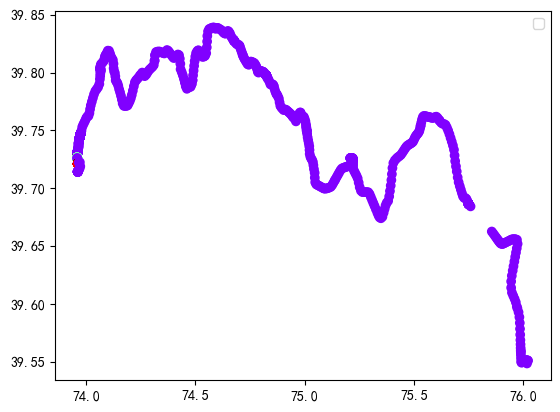

In [141]:
plt.scatter(point[:, 0], point[:, 1], c=data['labels'], cmap='rainbow')
plt.legend()
plt.show()

In [142]:
# 保存数据
# data.to_excel("D:/data/399072003946/399072003946_kaer_jvlei.xlsx",index=True,header=True)